# **Scenario**
Your company is expanding its chatbot to support Spanish and French. You need to compare tokenization strategies (e.g., WordPiece vs. SentencePiece) and embedding spaces for these languages.

# **Objectives**
Tokenize multilingual text using different tokenizers (e.g., BERT, T5).
Analyze vocabulary overlap and subword splitting behavior.
Visualize embeddings using PCA to compare semantic similarity across languages.
# **Instructions**
**Tokenize multilingual sentences:** Use Hugging Face tokenizers (e.g., bert-base-multilingual-cased, t5-small) to tokenize parallel sentences in English, Spanish, and French (e.g., "Hello world" vs. "Hola mundo").

**Compare tokenization outputs:** Print tokenized outputs and note differences in vocabulary size, subword units, and special tokens. Calculate the percentage of shared tokens between languages.

**Extract embeddings:** Pass tokenized inputs through the models’ embedding layers. Average token embeddings to get sentence-level representations.

**Dimensionality reduction:** Apply PCA to reduce embeddings to 2D and plot them using matplotlib. Color points by language to check for clustering.

**Evaluate cross-lingual similarity:** Compute cosine similarity between embeddings of translated sentences (e.g., "cat" vs. "gato"). Discuss whether semantically similar sentences cluster together.

# **Evaluation Criteria**
Accurate tokenization and embedding extraction.
Meaningful comparison of tokenizer behaviors.
Clear visualization and interpretation of embedding spaces.

In [40]:
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import transformers

sentences = {
    "en": ["Hello world", "The cat sits on the mat"],
    "es": ["Hola mundo", "El gato se sienta en la alfombra"],
    "fr": ["Bonjour le monde", "Le chat est assis sur le tapis"]
}

models = {
    "bert": {
        "tokenizer": AutoTokenizer.from_pretrained("bert-base-multilingual-cased"),
        "model": AutoModel.from_pretrained("bert-base-multilingual-cased")
    },
    "t5": {
        "tokenizer": AutoTokenizer.from_pretrained("t5-small"),
        "model": AutoModel.from_pretrained("t5-small")
    }
}

def tokenize_sentences(tokenizer, sentences):
    tokenized = {}
    for lang, sents in sentences.items():
        tokenized[lang] = [tokenizer.tokenize(sent) for sent in sents]
    return tokenized

# Print tokenizations
for name, assets in models.items():
    print(f"\n--- Tokenizer: {name} ---")
    tok = tokenize_sentences(assets['tokenizer'], sentences)
    for lang, toks in tok.items():
        print(f"{lang.upper()} Tokens: {toks}")






--- Tokenizer: bert ---
EN Tokens: [['Hello', 'world'], ['The', 'cat', 'sits', 'on', 'the', 'mat']]
ES Tokens: [['Ho', '##la', 'mundo'], ['El', 'ga', '##to', 'se', 'sien', '##ta', 'en', 'la', 'al', '##fo', '##mbra']]
FR Tokens: [['Bon', '##jou', '##r', 'le', 'monde'], ['Le', 'chat', 'est', 'ass', '##is', 'sur', 'le', 'tapi', '##s']]

--- Tokenizer: t5 ---
EN Tokens: [['▁Hello', '▁world'], ['▁The', '▁cat', '▁sit', 's', '▁on', '▁the', '▁mat']]
ES Tokens: [['▁Hol', 'a', '▁mun', 'd', 'o'], ['▁El', '▁', 'gat', 'o', '▁se', '▁si', 'ent', 'a', '▁', 'en', '▁la', '▁al', 'f', 'omb', 'r', 'a']]
FR Tokens: [['▁Bonjour', '▁le', '▁monde'], ['▁Le', '▁chat', '▁est', '▁', 'assi', 's', '▁sur', '▁le', '▁tap', 'is']]


In [41]:
def extract_unique_tokens(tokenizer, sentences):
    tokens = set()
    for sent in sentences:
        tokens.update(tokenizer.tokenize(sent))
    return tokens

for name, assets in models.items():
    print(f"\n--- {name.upper()} Vocab Overlap ---")
    tokenizer = assets['tokenizer']
    vocab = {lang: extract_unique_tokens(tokenizer, sents) for lang, sents in sentences.items()}

    en_tokens = vocab["en"]
    for lang in ["es", "fr"]:
        overlap = en_tokens & vocab[lang]
        percent = 100 * len(overlap) / len(vocab[lang])
        print(f"EN-{lang.upper()} shared: {percent:.2f}% ({len(overlap)} tokens)")



--- BERT Vocab Overlap ---
EN-ES shared: 0.00% (0 tokens)
EN-FR shared: 0.00% (0 tokens)

--- T5 Vocab Overlap ---
EN-ES shared: 0.00% (0 tokens)
EN-FR shared: 8.33% (1 tokens)


In [42]:
def sentence_embedding(model, tokenizer, sentence):
    # For T5, we need to provide a dummy decoder input
    if isinstance(tokenizer, transformers.models.t5.tokenization_t5_fast.T5TokenizerFast):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        # Use the same input IDs for the decoder as the encoder
        decoder_input_ids = inputs.input_ids
        outputs = model(**inputs, decoder_input_ids=decoder_input_ids)
    else: # For BERT, we can use the original logic
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.squeeze(0)
    avg_emb = embeddings.mean(dim=0)
    return avg_emb

def get_all_embeddings(model, tokenizer, sentences):
    embeddings = []
    labels = []
    for lang, sents in sentences.items():
        for sent in sents:
            emb = sentence_embedding(model, tokenizer, sent)
            # Detach the tensor from the computational graph before converting to NumPy
            embeddings.append(emb.detach().numpy())
            labels.append(lang)
    return np.array(embeddings), labels


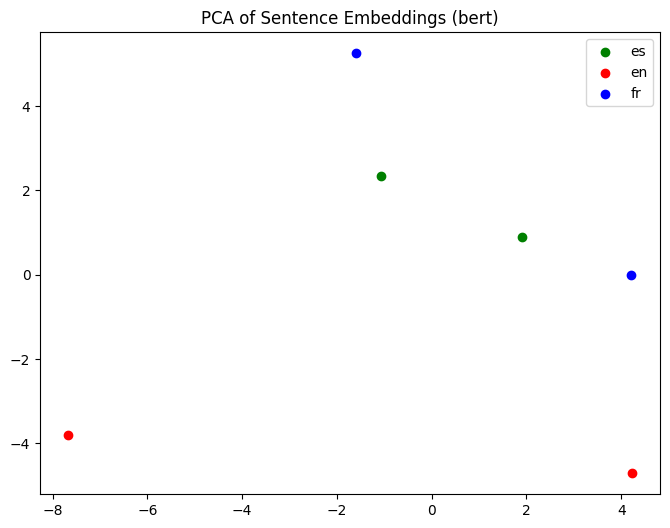

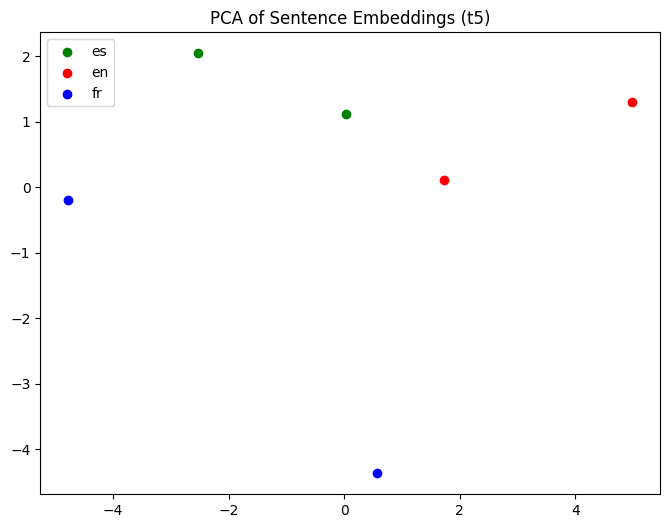

In [43]:
def visualize_embeddings(embeddings, labels, model_name):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    colors = {'en': 'red', 'es': 'green', 'fr': 'blue'}
    plt.figure(figsize=(8, 6))
    for lang in set(labels):
        idxs = [i for i, l in enumerate(labels) if l == lang]
        plt.scatter(reduced[idxs, 0], reduced[idxs, 1], label=lang, color=colors[lang])
    plt.title(f"PCA of Sentence Embeddings ({model_name})")
    plt.legend()
    plt.show()

# Run visualization
for name, assets in models.items():
    embs, langs = get_all_embeddings(assets["model"], assets["tokenizer"], sentences)
    visualize_embeddings(embs, langs, name)


In [44]:
test_words = [("cat", "gato", "chat")]

def word_embedding(model, tokenizer, word):
    tokens = tokenizer(word, return_tensors="pt")
    # For T5, provide decoder_input_ids
    if isinstance(tokenizer, transformers.models.t5.tokenization_t5_fast.T5TokenizerFast):
        decoder_input_ids = tokens.input_ids  # Use the same input IDs for the decoder
        with torch.no_grad():
            output = model(**tokens, decoder_input_ids=decoder_input_ids)
    else: # For BERT, use original logic
        with torch.no_grad():
            output = model(**tokens)
    return output.last_hidden_state[0].mean(dim=0).numpy()

for model_name, assets in models.items():
    print(f"\n--- Cosine Similarities ({model_name.upper()}) ---")
    for eng, esp, fra in test_words:
        e = word_embedding(assets['model'], assets['tokenizer'], eng)
        s = word_embedding(assets['model'], assets['tokenizer'], esp)
        f = word_embedding(assets['model'], assets['tokenizer'], fra)

        print(f"EN-ES ({eng}-{esp}): {cosine_similarity([e], [s])[0][0]:.4f}")
        print(f"EN-FR ({eng}-{fra}): {cosine_similarity([e], [f])[0][0]:.4f}")



--- Cosine Similarities (BERT) ---
EN-ES (cat-gato): 0.6106
EN-FR (cat-chat): 0.6746

--- Cosine Similarities (T5) ---
EN-ES (cat-gato): 0.9475
EN-FR (cat-chat): 0.8834
